In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from xgboost import XGBClassifier
from imblearn import over_sampling

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
N_SEED = 19
TOP_K = 5
VERBOSE = 1
N_JOBS = 4

COLOR_MAP = "RdYlBu"
L_FONT = {
    "color": "darkblue",
    "size": 11
}

T_COLOR = "darkred"

np.random.seed(N_SEED)
plt.style.use("ggplot")

In [3]:
dataset = pd.read_csv("../data/Churn_Modelling.csv")

## EDA

In [4]:
dataset.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
dataset.select_dtypes(include=["object"]).columns

Index(['Surname', 'Geography', 'Gender'], dtype='object')

In [7]:
dataset.select_dtypes(include=["int64", "float64"]).columns

Index(['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [8]:
dataset.isnull().values.sum()

np.int64(0)

In [9]:
dataset_transformed = dataset.drop(columns=["RowNumber", "CustomerId", "Surname"], axis=1)

In [10]:
geography_col = LabelEncoder().fit_transform(dataset["Geography"])
gender_col = LabelEncoder().fit_transform(dataset["Gender"])
y_dataset = dataset["Exited"]

In [11]:
dataset_transformed.drop(columns=["Geography", "Gender", "Exited"], axis=1, inplace=True)

In [12]:
dataset_transformed["Geography"] = pd.Series(geography_col)
dataset_transformed["Gender"] = pd.Series(gender_col)
dataset_transformed["Exited"] = pd.Series(y_dataset)

In [13]:
def show_corr(features, target):
    features.corrwith(target).plot.bar(color="purple", grid=True)
    ax = plt.gca()
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(T_COLOR)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(T_COLOR)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();

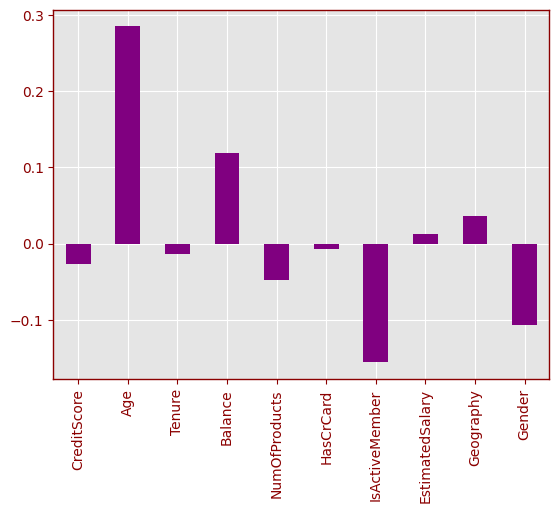

In [14]:
X_dataset = dataset_transformed.drop(columns=["Exited"], axis=1)
show_corr(X_dataset, y_dataset)

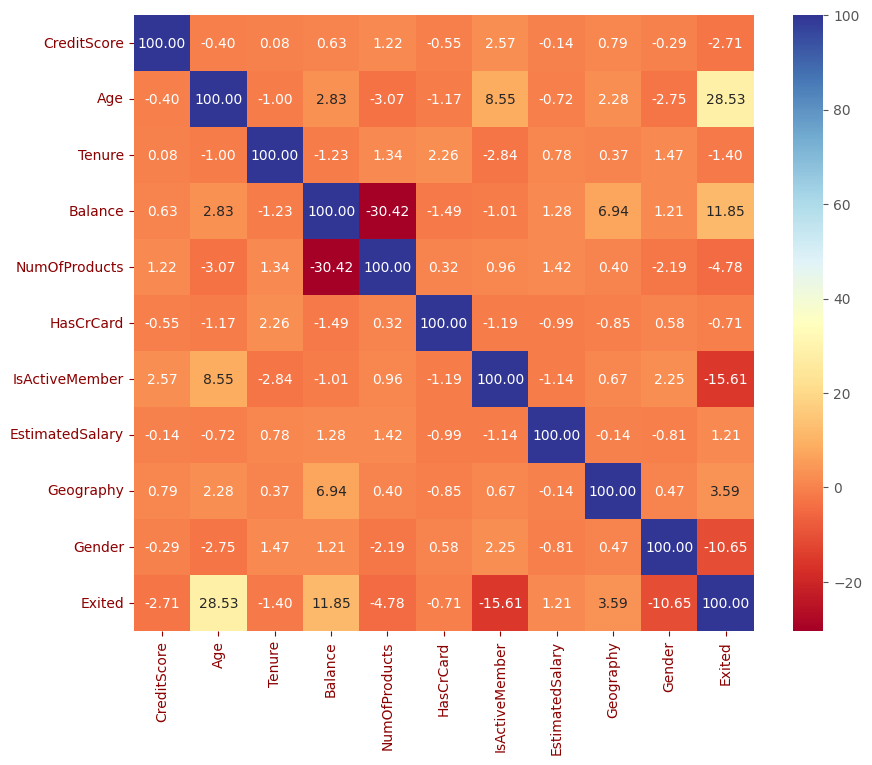

In [15]:
corr = dataset_transformed.corr() * 100
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap=COLOR_MAP, fmt=".2f")
ax = plt.gca()
ax.spines["bottom"].set_color(T_COLOR)
ax.spines["top"].set_color(T_COLOR)
ax.spines["left"].set_color(T_COLOR)
ax.spines["right"].set_color(T_COLOR)
ax.tick_params(axis="x", colors=T_COLOR)
ax.tick_params(axis="y", colors=T_COLOR)
plt.show();

In [16]:
# X_dataset = X_dataset.drop(columns=["HasCrCard"], axis=1)

X = np.array(X_dataset)
y = np.array(y_dataset).reshape(-1, 1)

In [17]:
# Scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [18]:
_, counts = np.unique(y, return_counts=True)
class_ratio = counts[0]/counts[1]
class_ratio

np.float64(3.9091801669121256)

In [19]:
def plot_features(x, target):
    _, col = x.shape
    for i in range(col):
        plt.hist(x[:, i], color="green")
        plt.xlabel("X: {i}".format(i=i), fontdict=L_FONT)
        plt.ylabel("Population", fontdict=L_FONT)
        ax = plt.gca()
        ax.spines["bottom"].set_color(T_COLOR)
        ax.spines["top"].set_color(None)
        ax.spines["left"].set_color(T_COLOR)
        ax.spines["right"].set_color(None)
        ax.tick_params(axis="x", colors=T_COLOR)
        ax.tick_params(axis="y", colors=T_COLOR)
        plt.show();


def plot_class_dist(target):
    unique, counts = np.unique(target, return_counts=True)
    plt.bar(unique, counts, color="darkblue",)
    plt.xlabel("Class", fontdict=L_FONT)
    plt.ylabel("Population", fontdict=L_FONT)
    ax = plt.gca()
    ax.set_xticks(ticks=unique, labels=unique)
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(None)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(None)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();


def plot_roc(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr, color="darkblue", label="AUC = %0.4f" % roc_auc,)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("TPR", fontdict=L_FONT)
    plt.xlabel("FPR", fontdict=L_FONT)
    ax = plt.gca()
    ax.set_title("Receiver Operating Characteristic", fontdict={"color": "darkblue"})
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(None)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(None)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();


def plot_classification(y_true, y_pred):
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred)
    sns.heatmap(
        (precision*100, recall*100, f1*100),
        annot=True, cmap=COLOR_MAP,
        fmt=".4f",
        yticklabels=("precision", "recall", "f1")
    )
    ax = plt.gca()
    ax.set_title("Classification Report", fontdict=L_FONT)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();

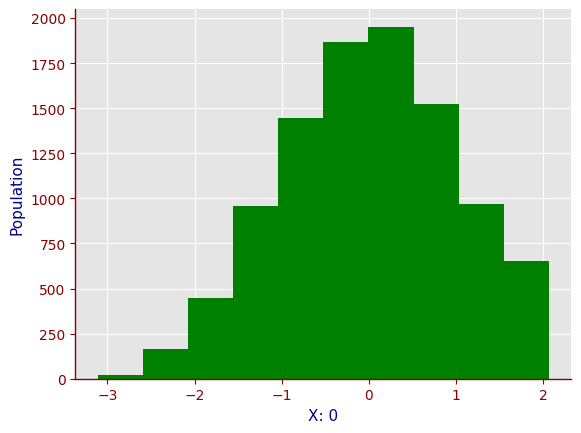

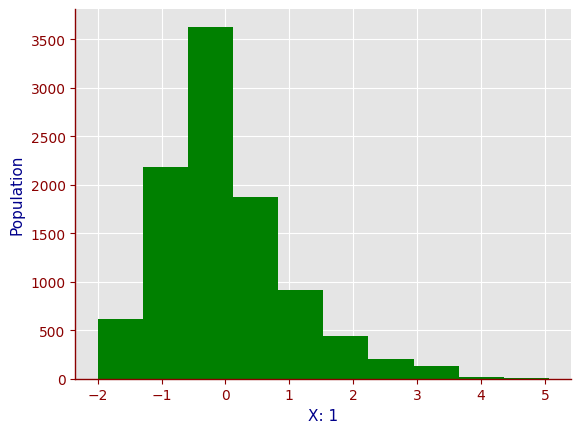

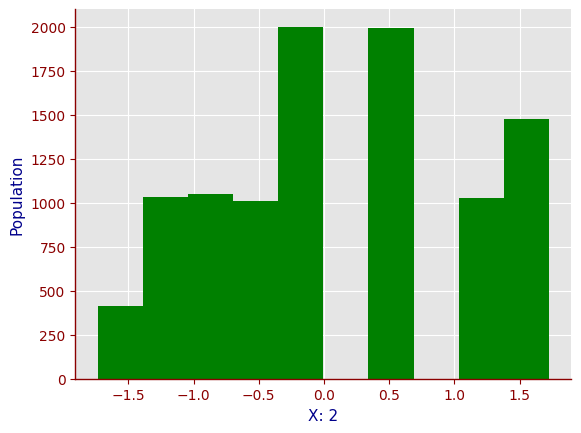

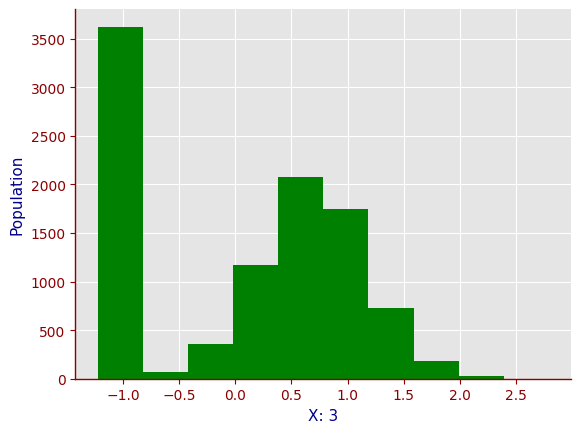

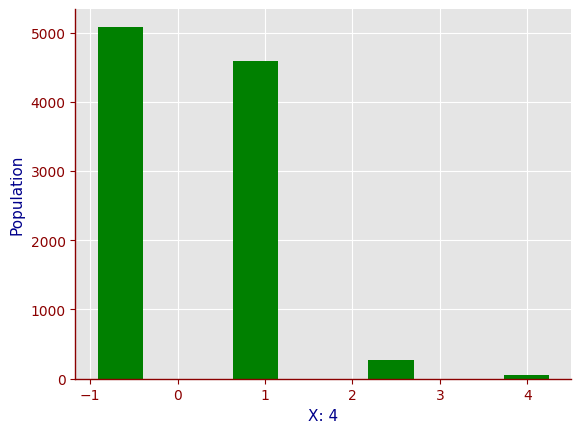

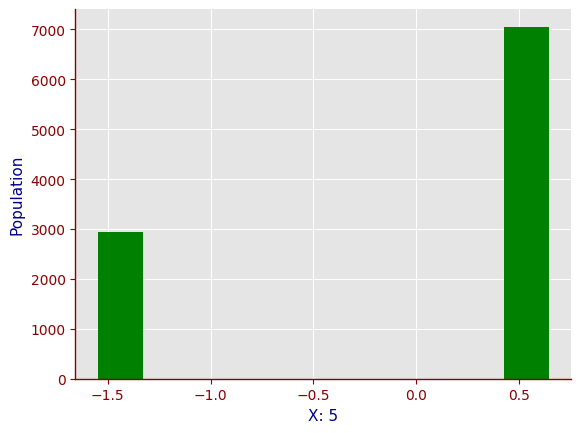

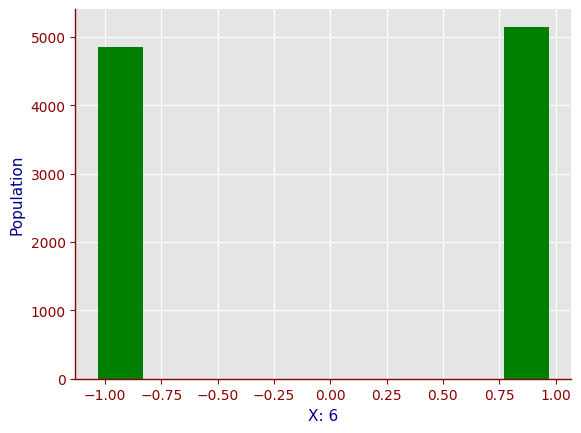

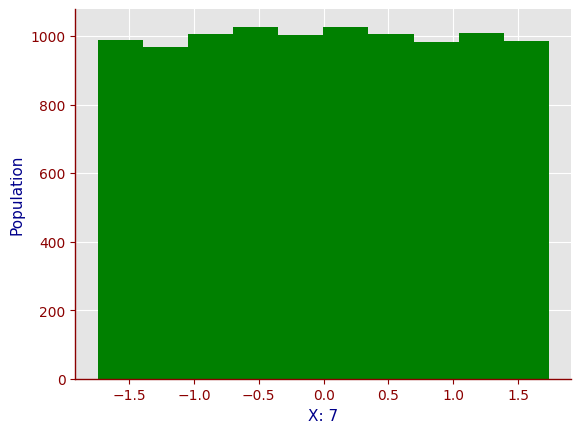

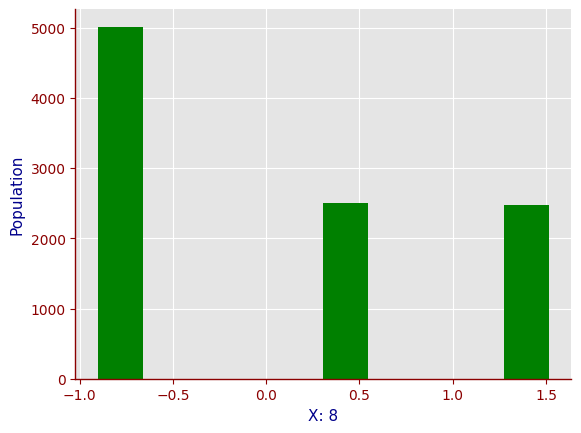

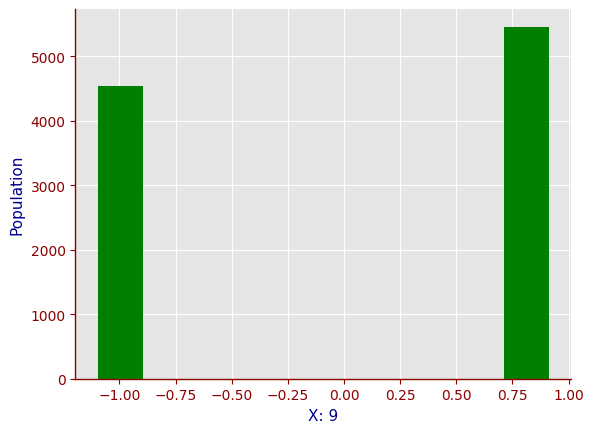

In [20]:
plot_features(X, y)

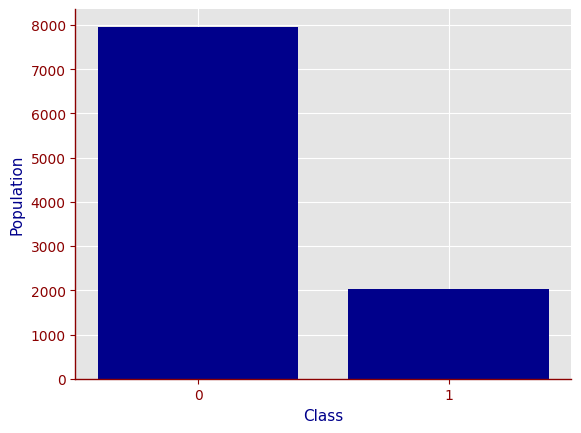

In [21]:
plot_class_dist(y)

In [22]:
X0_train, X0_test, y0_train, y0_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=N_SEED,
    shuffle=True,
    stratify=y
)

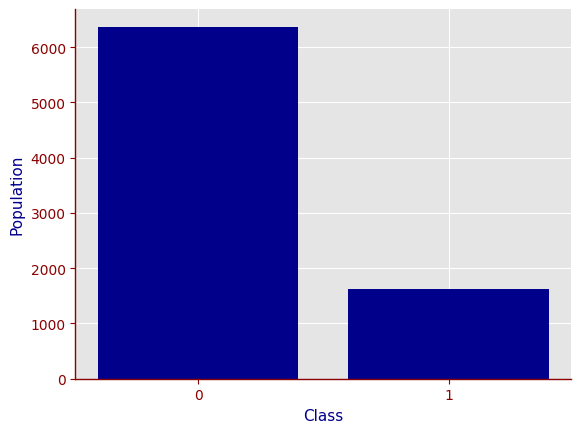

In [23]:
plot_class_dist(y0_train)

## Over Sampling train dataset

In [24]:
over_sampler = over_sampling.BorderlineSMOTE(
    sampling_strategy="minority",
    random_state=N_SEED,
)

X_train, y_train = over_sampler.fit_resample(X0_train, y0_train)
X_test, y_test = X0_test, y0_test

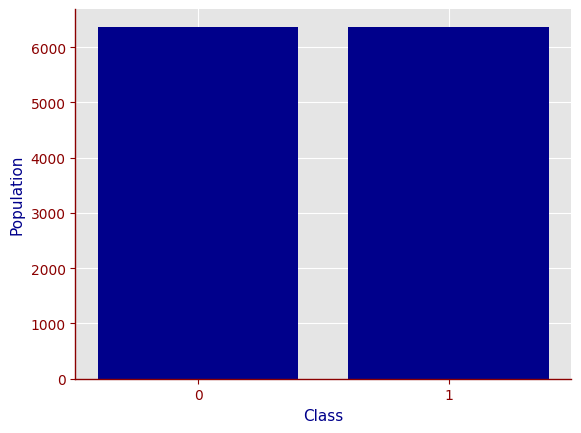

In [25]:
plot_class_dist(y_train)

## Logistic Regression

In [26]:
param_grid_LGR = {
    "solver": ["newton-cholesky"],
    "penalty": ["l2", None],
}

grid_search_cv_LGR = GridSearchCV(
    LogisticRegression(
        n_jobs=N_JOBS,
        random_state=N_SEED,
        verbose=VERBOSE,
    ),
    param_grid=param_grid_LGR,
    refit=True,
)

pipeline_LGR = make_pipeline(
    grid_search_cv_LGR,
)

pipeline_LGR.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Newton iter=1
  Check Convergence
    1. max |gradient| 0.019008233616457957 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.0011659014610597089 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 5.276041701231764e-06 <= 0.0001
    2. Newton decrement 8.50294435343829e-06 <= 0.0001
  Solver did converge at loss = 0.598807498229437.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Newton iter=1
  Check Convergence
    1. max |gradient| 0.0209562821751657 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.0013697485928678894 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 7.113193415524168e-06 <= 0.0001
    2. Newton decrement 1.0810773209739663e-05 <= 0.0001
  Solver did converge at loss = 0.5948176774101086.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Newton iter=1
  Check Convergence
    1. max |gradient| 0.02124432118683601 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.0014151635554221472 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 7.659139078781426e-06 <= 0.0001
    2. Newton decrement 1.1635916406447611e-05 <= 0.0001
  Solver did converge at loss = 0.5943740019323667.
Newton iter=1
  Check Convergence
    1. max |gradient| 0.02115395093596761 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.001414813359525557 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 7.721410357943117e-06 <= 0.0001
    2. Newton decrement 1.1794848229972692e-05 <= 0.0001
  Solver did converge at loss = 0.5934555838367762.
Newton iter=1
  Check Convergence
    1. max |gradient| 0.02063427422058455 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.0013201330003533502 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 6.539668245030437e-06 <= 0.00

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(estimator=LogisticRegression(n_jobs=4,
                                                           random_state=19,
                                                           verbose=1),
                              param_grid={'penalty': ['l2', None],
                                          'solver': ['newton-cholesky']}))])

In [27]:
grid_search_cv_LGR.cv_results_

{'mean_fit_time': array([0.42004647, 0.01277719]),
 'std_fit_time': array([0.45145361, 0.00046842]),
 'mean_score_time': array([0.00059156, 0.00044584]),
 'std_score_time': array([2.59976954e-04, 9.14620407e-05]),
 'param_penalty': masked_array(data=['l2', None],
              mask=[False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_solver': masked_array(data=['newton-cholesky', 'newton-cholesky'],
              mask=[False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'params': [{'penalty': 'l2', 'solver': 'newton-cholesky'},
  {'penalty': None, 'solver': 'newton-cholesky'}],
 'split0_test_score': array([0.69309262, 0.69309262]),
 'split1_test_score': array([0.69309262, 0.69309262]),
 'split2_test_score': array([0.67621664, 0.67621664]),
 'split3_test_score': array([0.67072214, 0.67072214]),
 'split4_test_score': array([0.6966248, 0.6966248]),
 'mean_test_score': array([0.68594976, 0.68594976]),
 'std_test_score': array([0.0104

In [28]:
y_pred_LGR = pipeline_LGR.predict(X_test)
y_prob_LGR = pipeline_LGR.predict_proba(X_test) * 100
cm_LGR = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_LGR)

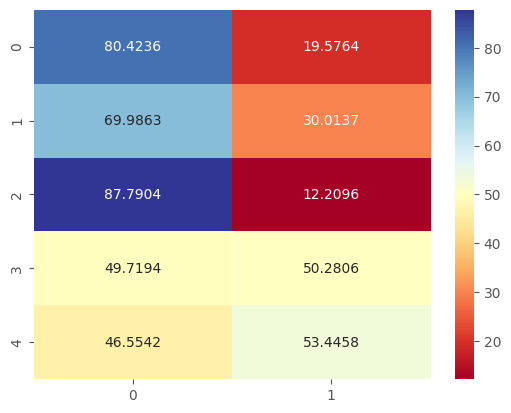

In [29]:
sns.heatmap(y_prob_LGR[:TOP_K], annot=True, cmap=COLOR_MAP, fmt=".4f");

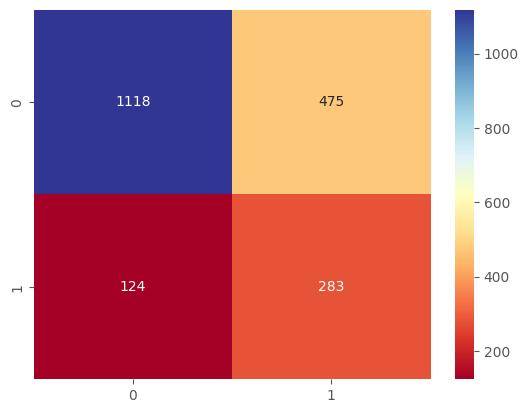

In [30]:
sns.heatmap(cm_LGR, annot=True, cmap=COLOR_MAP, fmt=".0f");

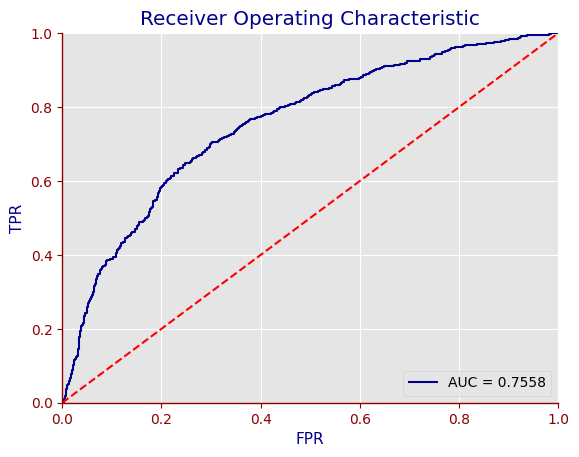

In [31]:
fpr_LGR, tpr_LGR, _ = metrics.roc_curve(y_test, y_prob_LGR[:, 1])
roc_auc_LGR = metrics.auc(fpr_LGR, tpr_LGR)
plot_roc(fpr_LGR, tpr_LGR, roc_auc_LGR)

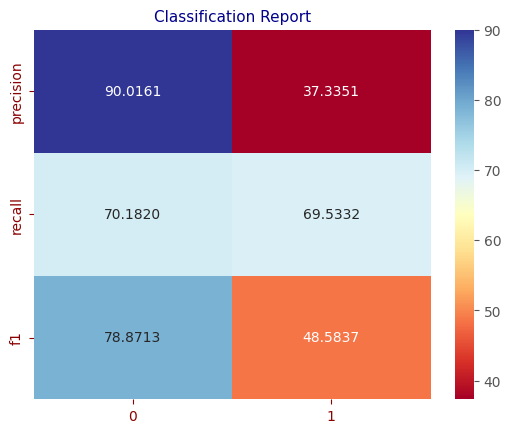

In [32]:
plot_classification(y_true=y_test, y_pred=y_pred_LGR)

In [33]:
metrics.accuracy_score(y_true=y_test, y_pred=y_pred_LGR)

0.7005

## Random Forest Classifier

In [34]:
param_grid_RFC = {
}

grid_search_cv_RFC = GridSearchCV(
    RandomForestClassifier(
        n_jobs=N_JOBS,
        random_state=N_SEED,
        verbose=VERBOSE,
    ),
    param_grid=param_grid_RFC,
    refit=True,
)

pipeline_RFC = make_pipeline(
    grid_search_cv_RFC,
)

pipeline_RFC.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_job

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(estimator=RandomForestClassifier(n_jobs=4,
                                                               random_state=19,
                                                               verbose=1),
                              param_grid={}))])

In [35]:
grid_search_cv_RFC.cv_results_

{'mean_fit_time': array([0.31113734]),
 'std_fit_time': array([0.02473338]),
 'mean_score_time': array([0.01583762]),
 'std_score_time': array([0.00391134]),
 'params': [{}],
 'split0_test_score': array([0.83987441]),
 'split1_test_score': array([0.90502355]),
 'split2_test_score': array([0.93720565]),
 'split3_test_score': array([0.9277865]),
 'split4_test_score': array([0.92072214]),
 'mean_test_score': array([0.90612245]),
 'std_test_score': array([0.03475243]),
 'rank_test_score': array([1], dtype=int32)}

In [36]:
y_pred_RFC = pipeline_RFC.predict(X_test)
y_prob_RFC = pipeline_RFC.predict_proba(X_test) * 100
cm_RFC = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_RFC)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


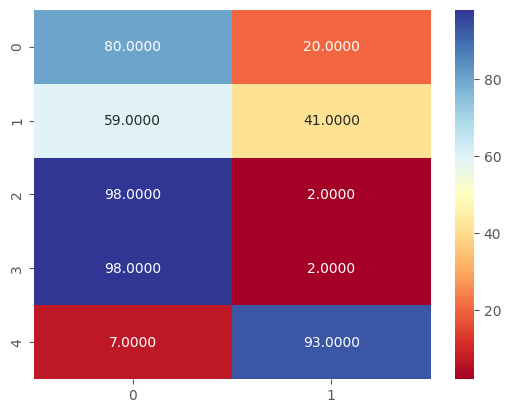

In [37]:
sns.heatmap(y_prob_RFC[:TOP_K], annot=True, cmap=COLOR_MAP, fmt=".4f");

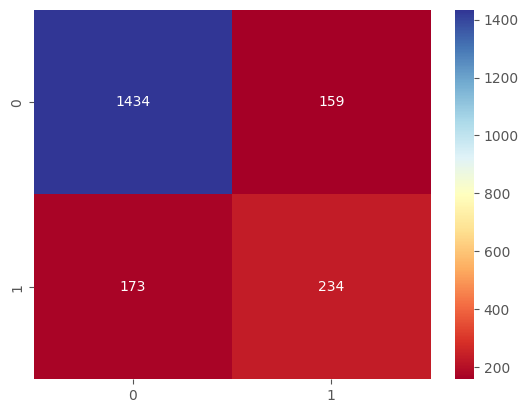

In [38]:
sns.heatmap(cm_RFC, annot=True, cmap=COLOR_MAP, fmt=".0f");

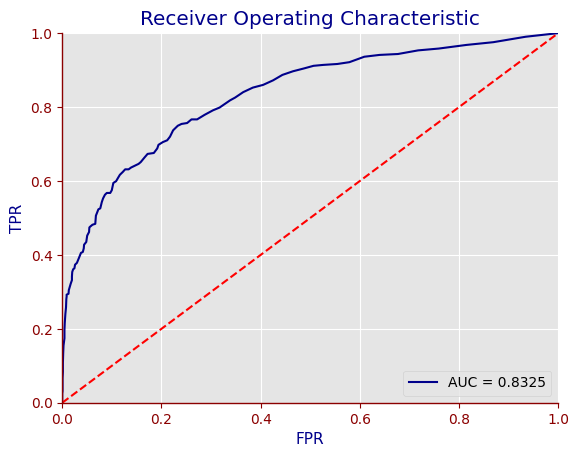

In [39]:
fpr_RFC, tpr_RFC, _ = metrics.roc_curve(y_test, y_prob_RFC[:, 1])
roc_auc_RFC = metrics.auc(fpr_RFC, tpr_RFC)
plot_roc(fpr_RFC, tpr_RFC, roc_auc_RFC)

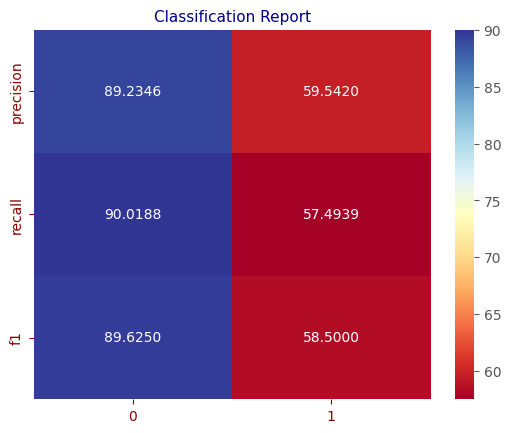

In [40]:
plot_classification(y_true=y_test, y_pred=y_pred_RFC)

In [41]:
metrics.accuracy_score(y_true=y_test, y_pred=y_pred_RFC)

0.834

## XGBoost

In [42]:
params_XGB = {
    "n_jobs": N_JOBS,
    "verbosity": VERBOSE,
}

param_grid_XGB = {
    "eta": [0.1, 0.3, 0.5],
    "max_depth": [3, 6, 8, 10]
}

model_XGB = XGBClassifier(**params_XGB)

grid_search_cv_XGB = GridSearchCV(
    model_XGB,
    param_grid=param_grid_XGB,
    refit=True,
)

pipeline_XGB = make_pipeline(
    grid_search_cv_XGB,
)

pipeline_XGB.fit(X_train, y_train)

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=4,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              param_grid={'eta': [0.1, 0.3, 0.5],
                                          'max_depth': [3, 6, 8, 10]}))])

In [43]:
grid_search_cv_XGB.cv_results_

{'mean_fit_time': array([0.0540606 , 0.09405198, 0.1457015 , 0.20034442, 0.04431477,
        0.08582821, 0.12746119, 0.18106785, 0.04737458, 0.08688679,
        0.13295121, 0.1669755 ]),
 'std_fit_time': array([0.0115616 , 0.00433447, 0.01799877, 0.00647642, 0.0006225 ,
        0.00112728, 0.00627779, 0.01471102, 0.00071151, 0.00180624,
        0.00742135, 0.00637064]),
 'mean_score_time': array([0.00101614, 0.00167003, 0.00228629, 0.00307193, 0.0009326 ,
        0.00156555, 0.0021359 , 0.00310836, 0.0009798 , 0.0015348 ,
        0.00224643, 0.0032331 ]),
 'std_score_time': array([4.53364072e-05, 1.36959021e-04, 1.49150562e-04, 2.64397308e-04,
        2.37566379e-05, 7.98540099e-05, 4.41458509e-05, 2.05517236e-04,
        5.47264077e-05, 2.23649336e-05, 1.11861810e-04, 1.56127627e-04]),
 'param_eta': masked_array(data=[0.1, 0.1, 0.1, 0.1, 0.3, 0.3, 0.3, 0.3, 0.5, 0.5, 0.5,
                    0.5],
              mask=[False, False, False, False, False, False, False, False,
            

In [44]:
y_pred_XGB = pipeline_XGB.predict(X_test)
y_prob_XGB = pipeline_XGB.predict_proba(X_test) * 100
cm_XGB = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_XGB)

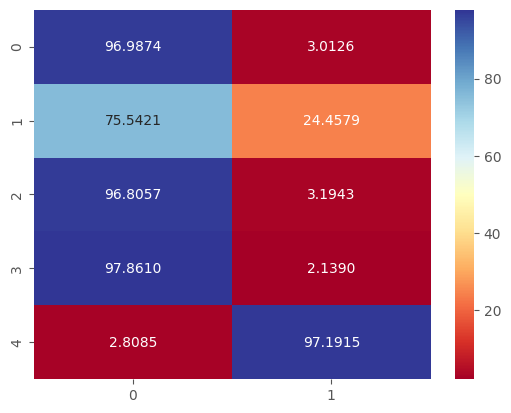

In [45]:
sns.heatmap(y_prob_XGB[:TOP_K], annot=True, cmap=COLOR_MAP, fmt=".4f");

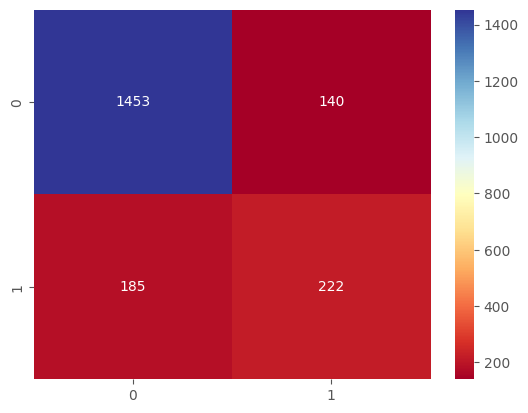

In [46]:
sns.heatmap(cm_XGB, annot=True, cmap=COLOR_MAP, fmt=".0f");

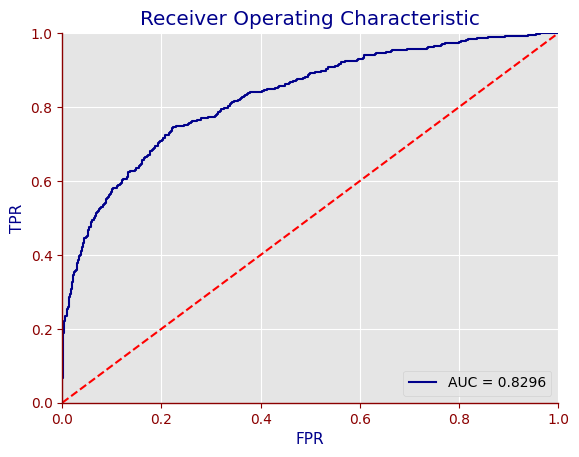

In [47]:
fpr_XGB, tpr_XGB, _ = metrics.roc_curve(y_test, y_prob_XGB[:, 1])
roc_auc_XGB = metrics.auc(fpr_XGB, tpr_XGB)
plot_roc(fpr_XGB, tpr_XGB, roc_auc_XGB)

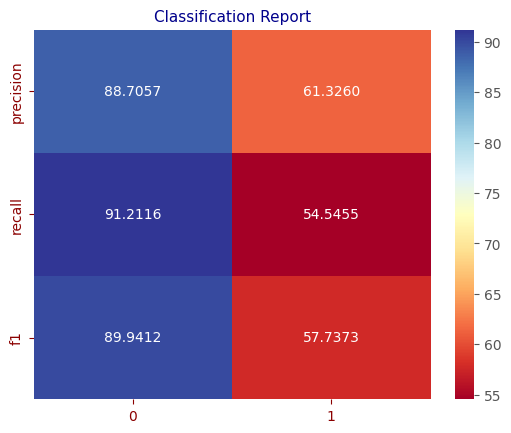

In [48]:
plot_classification(y_true=y_test, y_pred=y_pred_XGB)

In [49]:
metrics.accuracy_score(y_true=y_test, y_pred=y_pred_XGB)

0.8375